# <center>  Validation of Reservoir Model (RM) for formation </center>


<b>Idea:</b> The main idea of this tutorial is to demonstrate that the results of the Reservoir Model (RM) (i.e., averaging lithium concentration along the particle) can closely approximate the behavior of the Doyle-Fuller-Newman model (DFN) during relatively low C-rate cycling.





<div class="alert alert-block alert-danger"> <b>Goal</b>  
  <ol>
  <li>It can be used to save CPU time for a large number of cycles
  <li>The model can be used for comparing performance at different C-rates</li>
  <li>It can be used with different SEI growth models</li>
  <li>The mathematical model is much simpler and has fewer parameters</li>
</ol>
</div>

In [2]:
# Import the PyBaMM and essentials packages, as well as a set of parameters.
import pybamm
import numpy as np
import matplotlib.pyplot as plt
param = pybamm.ParameterValues("Chen2020")

Set initial conditions for the SEI thickness (default is 5 nm) very small, as we are interested in formation.

In [13]:
param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12

Remember, 'experiment' is a string-based way to set up how the battery will be cycled. (More information can be found in [Tutorial 5](https://docs.pybamm.org/en/latest/source/examples/notebooks/getting_started/tutorial-5-run-experiments.html)

The charging and discharging rates may vary, and we can create a list of them for comparison purposes. Consequently, we can compile a list of experiments, each with a different number of cycles.


In [4]:
# These three lists must be the same length.
ch_c_rates = ["C/5", "C/10", "C/30"]
dch_c_rates = ["C/5", "C/10", "C/30"]
no_cycles = [5, 5, 5]
exps = [pybamm.Experiment(
    [("Charge at {} until 4.2 V".format(ch_c_rates[i]),
      "Rest for 10 hours",
      "Discharge at {} until 2.5 V".format(dch_c_rates[i]),
      )] * no_cycles[i],
) for i in range(len(ch_c_rates))]

Creating Reservoir Model (RM) and Doyle-Fuller-Newman (DFN) models with specified options for different SEI model variants. More options can be added [here](https://docs.pybamm.org/en/latest/source/api/models/base_models/base_battery_model.html#pybamm.BatteryModelOptions).

In [15]:
sei_models = ["reaction limited", "solvent-diffusion limited",
              "interstitial-diffusion limited", "ec reaction limited"]

# Diffferent SEI models can be used, by setting the index of sei_models
index = 0
options1 = {"SEI": sei_models[index],
            "SEI porosity change": "true"}  # which is default
options2 = {"particle": "uniform profile",
            "SEI": sei_models[index], "SEI porosity change": "true"}


name_models = ["DFN", "RM"]  # This is for the legend
models = [
    pybamm.lithium_ion.DFN(options=options1, name=name_models[0]),
    pybamm.lithium_ion.SPM(options=options2, name=name_models[1]),

]  # models is a list,  in this example it is only two  models but could be more

Creating list of simulations for all models and experiments with specified parameters.

In [16]:
# please note that the size of sims will be equal to the number of models times the number of experiments
sims = [pybamm.Simulation(model, parameter_values=param, experiment=exp)
        for exp in exps for model in models]

Combine all solutions for the different C-rates and models in the 'sols' list with an initial SOC of 0, as we assume the battery is undergoing its first-time charging and discharging slowly.

In [17]:
sols = [sim.solve(initial_soc=0) for sim in sims]

We are adding the output variables (variables for postprocessing) to the following list. 

You can find the list of existing output variables by typing the model name followed by 'dot variable_name()' – for example, here, 'models[0].variable_names()'.

In [18]:

out_vars = ['X-averaged negative particle surface concentration [mol.m-3]',
            "Voltage [V]",
            'X-averaged total SEI thickness [m]',
            'X-averaged negative electrode porosity',
            ]

# Label for the output variables y-axis in the plots
yaxis_labels = ["cn",  "Voltage", "SEI_thickness",
                "porosity"]

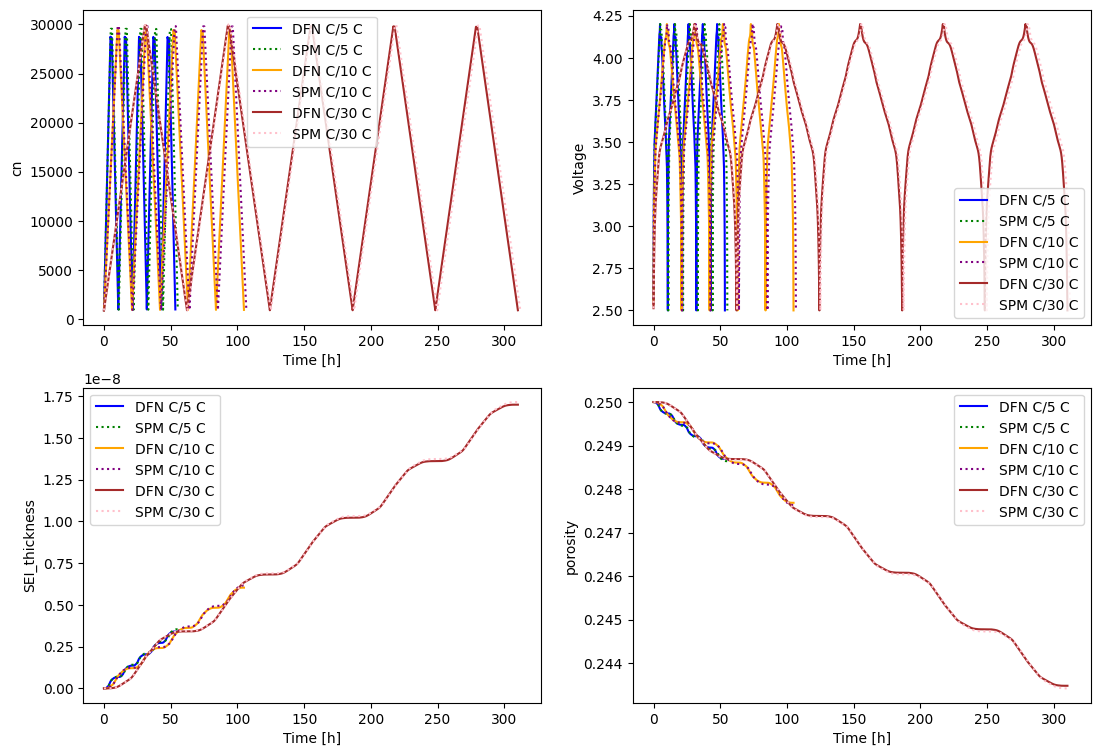

In [19]:

n = int(np.ceil(len(out_vars) / 2))
# generating labels for the plots
Labels = [f"{x} {y} C" for y in dch_c_rates for x in name_models]


fig, axs = plt.subplots(n, 2, figsize=(13, 9))   # sub plot

colors = ['blue', 'green', 'orange', 'purple',
          'brown', 'pink', 'gray', 'olive', 'cyan', 'black']
for i in range(n):  # Loop through the output veriables (out_vars)
    for sol in sols:  # Loop through the models
        line_style = "-" if sols.index(sol) % 2 == 0 else ":"
        axs[i, 0].plot(sol['Time [h]'].entries, sol[out_vars[2*i]].entries,
                       linestyle=line_style, color=colors[int(
                           sols.index(sol) % len(colors))],
                       label=Labels[sols.index(sol)])
#

        axs[i, 1].plot(sol["Time [h]"].entries, sol[out_vars[2*i+1]].entries,
                       linestyle=line_style, color=colors[int(
                           sols.index(sol) % len(colors))],
                       label=Labels[sols.index(sol)])
    axs[i, 0].set_xlabel("Time [h]")
    axs[i, 0].set_ylabel(yaxis_labels[2*i])
    axs[i, 0].legend()
    axs[i, 1].set_xlabel("Time [h]")
    axs[i, 1].set_ylabel(yaxis_labels[2*i+1])
    axs[i, 1].legend()

# axs[i, 1].set_ylabel(yaxis_labels[ sols.index(sol) % len(yaxis_labels)])
# print(sols.index(sol), yaxis_labels[ sols.index(sol) % len(yaxis_labels)])
# axs[i, 1].set_xlabel("Time [h]")

In [20]:
# For printing the solve time for each model
# for sol in sols:
#     print(sol.solve_time)

In [23]:
sol_cycles = {}  # Create an empty list to store cycles for all solutions

for sol in sols:
    sol_cycle = []  # Create an empty list for each solution
    for j in range(cycle_no):
        start_capacity = sol.cycles[j].steps[2]["Discharge capacity [A.h]"].entries[0]
        end_capacity = sol.cycles[j].steps[2]["Discharge capacity [A.h]"].entries[-1]
        # Append values to the list for the current solution
        sol_cycle.append(end_capacity - start_capacity)
    # plt.scatter(range(1, cycle_no+1, 1), sol_cycle)
    # plt.legend(Labels)
    # plt.xlabel("Cycle number")
    # plt.ylabel("Discharge capacity [A.h]")
    # Append the list for the current solution to the main lis
    sol_cycles[sols.index(sol)] = sol_cycle

Plot the relative error of discharge capacity at each cycle, i.e. (|DFN-RM|/DFN*100)

Text(0, 0.5, 'Relative error in discharge capacity [%]')

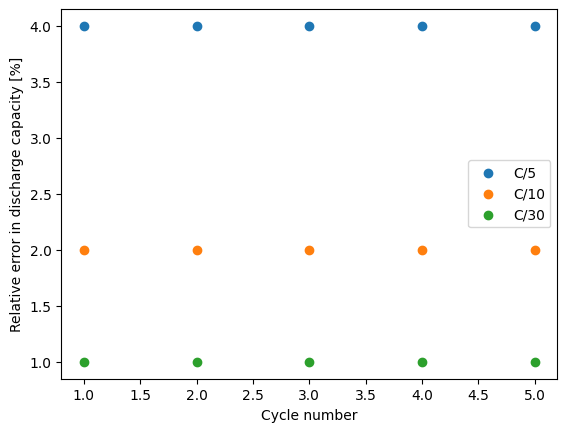

In [24]:
Relative_error_ineach_cycle = {}
for i in range(0, len(sol_cycles) - 1, 2):
    Relative_error_ineach_cycle[i] = [np.round(
        np.abs((a-b)/a)*100) for a, b in zip(sol_cycles[i], sol_cycles[i + 1])]
    plt.scatter(range(1, cycle_no+1, 1), Relative_error_ineach_cycle[i])
plt.legend(ch_c_rates)
plt.xlabel("Cycle number")
plt.ylabel("Relative error in discharge capacity [%]")